# Bootstrap Methods and Their Application

In [1]:
library(tidyverse)
library(boot)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


## 1. Introduction

The quantification of uncertainty is central to the statistical sciences. In simple situations the uncertainty of an estimate may be gauged through analytical methods based on the assumed probability model for the available data. But in more complicated problems this approach can be tedious and difficult, and its results potentially misleading if inappropriate assumptions or simplifications have been made. 

Bootstrap methods can be used as an alternative to obtain reliable measures of uncertainty for a wide range of problems by leverage computer simulation. The key idea is to resample from the original data, either directly or via a fitted model, to create duplicate data sets from which the the variability of the quantities of interest can be assessed. 

### Example 1.1 (Parametric)
Time between failures of airconditioning units:

#### Exponential Model $ \hat{\mu} = \bar{y} = 108.083 $
$$ F_\mu(y) = 
\begin{cases}
\begin{align}
0 \qquad &y \leqslant 0 \\
1 - e^{\frac{-y}{\mu}} \qquad &y > 0 \\
\end{align}
\end{cases}
$$

#### Gamma Model $ \bar{k} = 0.71, \quad \hat{\mu} = \frac{\bar{y}}{k} = 152.230 $ 
$$ F_\mu(y) = 
\begin{cases}
\begin{align}
0 \qquad &y \leqslant 0 \\
\frac{1}{\Gamma(k)} \, \gamma(k, \frac{y}{\mu}) \qquad &y > 0 \\
\end{align}
\end{cases}
$$


In [2]:
# MLE fit of exponential model to bootstrap data
library(MASS)
d = data.frame(y = c(3, 5, 7, 18, 43, 85, 91, 98, 100, 130, 230, 487))

fit.exp = fitdistr(d$y, 'exponential')
fit.exp
fit.gamma = fitdistr(d$y, 'gamma')
fit.gamma


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select



      rate    
  0.009252120 
 (0.002670857)

      shape         rate    
  0.706486392   0.006536497 
 (0.244012534) (0.003133911)

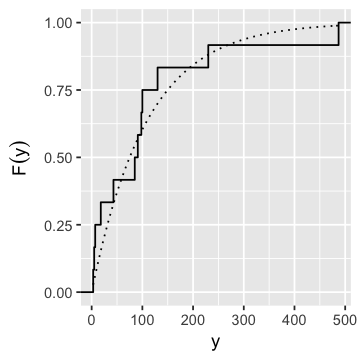

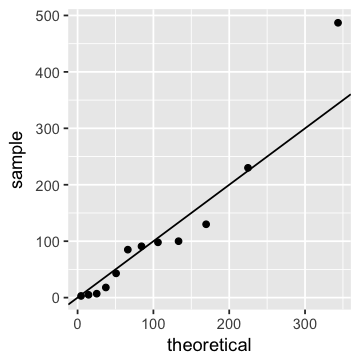

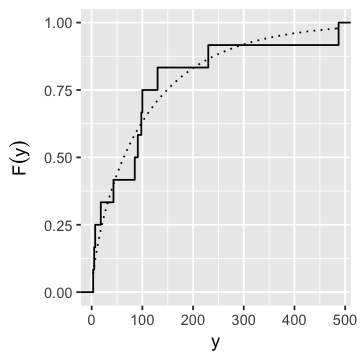

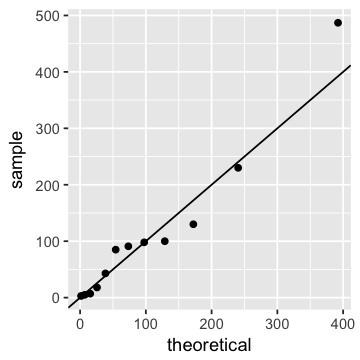

In [3]:
options(repr.plot.width=3, repr.plot.height=3)
rate.exp = fit.exp$estimate['rate']
shape = fit.gamma$estimate['shape']
rate.gamma = fit.gamma$estimate['rate']

# Exponential model
ggplot(data=d, aes(x=y)) + stat_ecdf() + 
    stat_function(fun = function(x) { pexp(x, rate=rate.exp)}, linetype='dotted') +
    ylab(expression(F(y)))
ggplot(data=d, aes(sample=y)) + 
    stat_qq(distribution = qexp, dparams = list(rate=rate.exp)) +
    geom_abline(intercept = 0, slope = 1)

# Gamma model
ggplot(data=d, aes(x=y)) + stat_ecdf() + 
    stat_function(fun = function(x) { pgamma(x, shape=shape, rate=rate.gamma) }, linetype='dotted') + 
    ylab(expression(F(y)))
ggplot(data=d, aes(sample=y)) + 
    stat_qq(distribution = qgamma, dparams = list(shape=shape, rate=rate.gamma)) +
    geom_abline(intercept = 0, slope = 1)

### Example 1.2 (Non-parametric)

$n = 49$ data pairs, each corresponding to a city in the United States, the pair being the population in 1920 and 1930 of the city which we denote as $(u,x)$. Interest here is in the ratio of the means, because this would enable us to to estimate the total population of the US in 1930 from the 1920 figure.

There is no obvious parametric model for the joint distribution of $(U,X)$ so it is natural to estimate $\theta$ by its empirical analog, $T = \frac{\bar{X}}{\bar{U}}$, the ratio of the sample averages.  We are then concerned with the statisitical properties of the estimator $T$. 

A parametric model would allow us to determine theoretically bias and variance of estimates of $T$ for use in a normal approximation, which would would provide approximate confidence intervals for $\theta$. Without such a model, we must use _non-parametric_ methods to estimate the bias and variance of $T$ which makes normal approximation still feaible, as well as more complex approaches to setting confidence intervals.

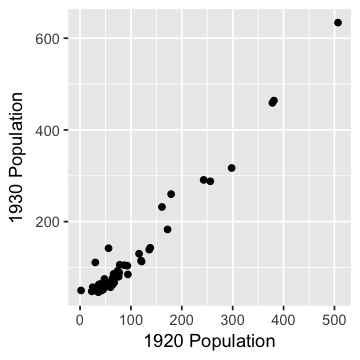

In [4]:
city = c(138, 143,
        93, 104, 
        61, 69,
        179, 260,
        48, 75, 
        37, 63,
        29, 50,
        23, 48,
        30, 111,
        2, 50,
        38, 52, 
        46, 53,
        71, 79,
        25, 57,
        298, 317, 
        74, 93,
        50, 58,
        76, 80,
        381, 464,
        378, 459,
        78, 106,
        60, 57,
        507, 634,
        50, 64,
        77, 89,
        64, 77,
        40, 60,
        136, 139,
        243, 291,
        256, 288,
        94, 85,
        36, 46,
        45, 53,
        67, 67,
        120, 115,
        172, 183,
        66, 86,
        46, 65,
        121, 113,
        44, 58,
        64, 63,
        56, 142,
        40, 64,
        116, 130,
        87, 105,
        43, 61,
        43, 50, 
        161, 232,
        36, 54) %>% matrix(ncol = 2, byrow = TRUE) %>% data.frame() %>% rename(u = X1, x = X2)

options(repr.plot.width=3, repr.plot.height=3)
ggplot(city, aes(x=u, y=x)) + geom_point() + xlab("1920 Population") + ylab("1930 Population")

## 2. The Basic Bootstraps

### 2.1 Introduction

__Scenario__: we have a single sample of data $y_1, y_2,...,y_n$ from a vector of independently and identically distributed variables $Y_1, Y_2,...,Y_n$ with _probability density function_ (PDF) and _cumulative distribution function_ (CDF) denoted $f$ and $F$ respectively.

The sample is to be used to make inferences about population characteristic $\theta$, using a statistic $T$ (as an estimator/test-statistic ???) whose value in the sample is $t$. Our goal is to use the sample data to characterize the distribution of T and thereby answer questions regarding bias, standard error, quantiles, hypothesis testing, and confidence intervals.

At this point we may take a __parametric__ approach in which we consider T to have an underlying mathematical model with parameters $\psi$ that fully determine the probability distribution $f$. In this case our parameter of interest, $\theta$, is a component or function of $\psi$ (why do we distinguish between the two ???).

Alternatively, we may take a __non-parametric__ approach where no mathematical model is used and analysis is based only on the assumtption that $Y_j$ are independent and identically distributed. This lack of assumptions in non-parametric analysis makes the approach typically more robust than parametric methods, albeit less precise when model assumptions hold. In non-parametric analysis, the __empirical distribution function__ (EDF) $\hat{F}$ plays the role of fitted model when no mathematical form is assumed for $F$. The EDF puts equal probabilites $\frac{1}{n}$ at each sample value $y_i$. The EDF is analogous to a parametric CDF with parameters replaced by their estimates. 

Many simple statistical functions can be thought of in terms of properties of the EDF. For example, the sample average $\bar{y} = \frac{1}{n} \Sigma{y_i}$ is the mean of the EDF. More generally, the statistic of interest $t$ will be a symmetric function of $y_1, y_2,...,y_n$, meaning that $t$ is unaffected by reordering of the data. This implies that $t$ depends only on the ordered values $y_{(1)}, y_{(2)},...,y_{(n)}$, or equivalently on the EDF $\hat{F}$. This can be expressed as $t = t(\hat{F})$, where $t(.)$ is a statistical function for computing $t$ from $\hat{F}$. Such a statistical function is central to the non-parametric case because it also defines the parameter of interest $\theta$ through the relationship $\theta = t(F)$. This corresponds to the idea that $\theta$ is a characteristic of the population described by $F$.

Simple examples of such functions $t(.)$ are the mean and variance of $Y$:

$$ t(F) = \int y \, dF(y) $$

$$ t(F) = \int y^2 \, dF(y) - \Big\{\int y \, dF(y) \Big\}^2 $$

Not all estimates are exactly of the form $t(\hat{F})$. For example, if $t(F) = Var(Y)$ then the usual unbiased sample variance is $nt(\hat{F})/(n-1)$. Such small discrepancies are fairly unimportant with respect to the bootstrap technique and we generally assume that $T = t(\hat{F})$.

The representation $\theta = t(F)$ defines the parameter and its estimator $T$ in without any assumptions about F. This property which guarantees that the correct characteristic of the underlying distribution is estimated, whatever the distribution, is sometimes called the __robustness of specification__.

Our main objective is approximation of the distribution of estimator $T$ on which we can base inferences about the parameter being estimated, $\theta$. Given the bias $\beta$ and variance $\nu$ of estimator $T$, we can derive confidence intervals for $\theta$ where

$$ \beta = b(F) = E(T|F) - \theta \quad \nu = v(F) = var(T|F) $$ 

and $T|F$ denotes that the random variables from which $T$ is calculated has distribution $F$.  In practice, however, $\beta$ and $\nu$ are not known and must be estimated by substituting $\hat{F}$ for $F$ above:

$$ B = b(\hat{F}) = E(T|\hat{F}) - t(\hat{F}),\quad \nu = v(\hat{F}) = var(T|\hat{F}) $$

Estimates such as these are __bootstrap__ estimates and can be applied more ambitiously to improve our estimation of $\beta$, $\nu$, and thereby inference on the parameter $\theta$. The elaboration of the bootstrap is the subject of this report.


### 2.2 Parametric Simulation

In the parametric bootstrap method, we empirically calculate the relevant properties of our estimator $T$ through repeated simulation of data sets from a fitted parametric model. 


#### 2.2.1 Moment Estimates
Suppose we have a parametric model for the distribution of the random variable $Y$: we denote the CDF and PDF of this model as $F_\psi(y)$ and $f_\psi(y)$ respectively. When $\psi$ is estimated by $\hat{\psi}$, its subsitution gives us a _fitted_ model with CDF $\hat{F(y)} = F_{\hat{\psi}}(y)$ which can be used to calculate properties of $T$. We shall use $Y^*$ to denote the random variable distributed according to the fitted model $\hat{F}$and we denote the statistic of interest calculated from a simulated dataset as $T^*$. From $R$ repetitions of the data simulation we obtain $T_1, T_2,..., T_R$ from which properties of $T - \theta$ are then estimated. For example, the estimator of the bias $ b(F) = E(T|F) - \theta $ is:

$$ B = b(\hat{F}) = E(T|\hat{F}) - t $$

and this in turn is estimated by 

$$ B_R = E(T^*) - t = \frac{1}{R} \sum_{r=1}^R T^*_r - t = \bar{T}^* - t \qquad (2.7) $$

Note that in the simulation $t$ is the parameter value for the model, so that $T^* - t$ is the simulation analogue of $T - \theta$. The corresponding estimator of the variance of $T$ is:

$$ V_R = \frac{1}{R - 1} \sum_{r=1}^R (T_r^* - \bar{T}^*) \qquad (2.8) $$

These empirical approximations are justified by the law of large numbers. It is important to recognise that we are not estimating absolute proerpties of $T$ but rather of $T$ relative to $\theta$. This usually involves the estimation error $T - \theta$ but some other measure of the error might be relevant depending on the context, like $T/\theta$ for exmaple.

#### Example 2.5

We use repeated sampling from the fitted exponential model in _Example 1.1_ to determine the properties of $T = \bar{Y}$ as an estimator of the population mean. Simulations show that the empirical bias and variance converge on the "correct" answers of zero and $\bar{y}^2/n = (108.083)^2/12 = 973.5$ as $R$ increases (are these answers correct wrt the assumed exponential model or the actual gamma distribution ???).

In this case, since the moments are easy to calculate theoretically, simulation is uneccessary. Also, we know the population to be gamma distributed so can determine the accuracy of our empirical approximations. In practice however, this is not the case and general rules are required to determine how large R should be.

In [5]:
1/mean(d$y)
fit.exp

[1] 0.00925212

      rate    
  0.009252120 
 (0.002670857)

In [6]:
# The statistical function we are using as an estimator: the sample mean in this case.
air.fun = function(data) {
    return(mean(data$y))
}

# Sampler function which generates random data from the parametric model which we fitted via MLE
air.rg = function(data, rate) {
        out = data
        out$y = rexp(nrow(out), rate = rate)
        return(out)
}

set.seed(1234)
b = boot(data=d, statistic=air.fun, R=10, sim='parametric', ran.gen=air.rg, mle=fit.exp$estimate['rate'])
b

# Show how boot() estimates bias and variance
#mean(b$t) - b$t0
#sd(b$t)


PARAMETRIC BOOTSTRAP


Call:
boot(data = d, statistic = air.fun, R = 10, sim = "parametric", 
    ran.gen = air.rg, mle = fit.exp$estimate["rate"])


Bootstrap Statistics :
    original    bias    std. error
t1* 108.0833 -6.969708    35.64608

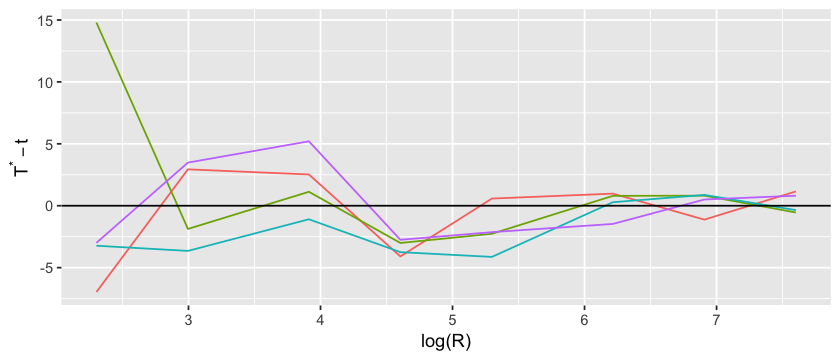

In [7]:
# Bias
set.seed(1234)
p = sapply(c(10, 20, 50, 100, 200, 500, 1000, 2000), function(r) {
        c(r, sapply(1:4, function(x) { 
            b = boot(data=d, statistic=air.fun, R=r, sim='parametric', ran.gen=air.rg, mle=fit.exp$estimate['rate'])
            return(mean(b$t) - b$t0)
        }))
    }) %>% t() %>% data.frame %>% rename(R=X1) %>% gather(name, Bias, -R)

options(repr.plot.width=7, repr.plot.height=3)
ggplot(data=p, aes(x=log(R), y=Bias, col=name)) + 
    geom_path() + geom_hline(yintercept = 0) + 
    ylab(expression(T^'*' -  t)) +
    theme(legend.position="none")

rate 
973.5006

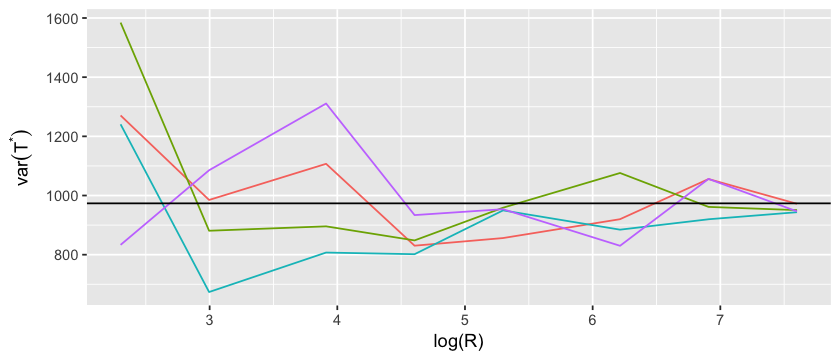

In [8]:
# Variance
set.seed(1234)
p = sapply(c(10, 20, 50, 100, 200, 500, 1000, 2000), function(r) {
        c(r, sapply(1:4, function(x) { 
            b = boot(data=d, statistic=air.fun, R=r, sim='parametric', ran.gen=air.rg, mle=fit.exp$estimate['rate'])
            return(var(b$t))
        }))
    }) %>% t() %>% data.frame %>% rename(R=X1) %>% gather(name, Variance, -R)

options(repr.plot.width=7, repr.plot.height=3)

# hline represents the estimated variance of the sampling distribution of the
# sample mean based on an the assumption of a exponential model fit on 
# the original sample: 1 / (rate^2 * n) 
theoretical_variance = 1 / (fit.exp$estimate['rate']^2 * length(d$y))
theoretical_variance
ggplot(data=p, aes(x=log(R), y=Variance, col=name)) + geom_path() + 
    geom_hline(yintercept = theoretical_variance) + 
    ylab(expression(var(T^'*'))) +
    theme(legend.position="none")

#### 2.2.2 Distribution and Quantile Estimates

Simulated estimates of bias and variance can be used with normal approximations of $T$, particularly for large samples, to make inferences regarding population parameters. However, a normal approximation is not always appropriate and the empirical distribution of our simulated values can provide a more accurate picture if $R$ is large enough, in principle, because they do not make any assumptions regarding the distribution of $T^* - t$.

##### Distribution
If, as is often the case, we are approximating the distribution of $T - \theta$ by $t^* - t$, then the cumulative probabilities are estimated by the empirical distribution function of the simulated values. More formally, if $G(u) = Pr(T-\theta \leqslant u)$, then the simulation estimate of $G(u)$ is:

$$ \hat{G}_R(u) = \frac{\#(t_r^*-t \leqslant u)}{R} = \frac{1}{R} \sum_{r=1}^R I(t_r^*-t \leqslant u) $$

As $R$ increases, this estimate will converge to $\hat{G}(u)$, the exact CDF of $T^* - t$ under sampling from the fitted model. Just as with moment estimation, the approximation $\hat{G}_R$ to $G$ contains two sources of error: that between $\hat{G}$ and $G$ due to data variability (affects the fitted model) and that between $\hat{G}_R$ and $\hat{G}$ due to finite simulation.


##### Quantiles
Quantiles of the distribution of $T - \theta$ are approximated using ordered values of $t^* - t$. The underlying result used here is that if $X_1, X_2,...,X_N$ are indendently distributed with CDF $K$ and if $X_{(j)}$ denotes the $j$th ordered values, then:

$$ E(X_{(j)}) \,\circeq\, K^{-1} \bigg(\frac{j}{N+1}\bigg) $$

_Note: $K^{-1}$ takes a probability and returns the quantile_

This implies that a sensible estimate of $K^{-1}(p)$ is $X_{((N+1)p)}$, assuming that $(N+1)p$ is an integer. So we estimate the $p$ quantile of $T - \theta$ by the $(R+1)p$th ordered value of $t^* - t$, that is $t^*_{((N+1)p)} - t$. We assume that $R$ is chosen so that $(R+1)p$ is an integer.

##### Density
It is sometimes useful to look at the density of $T$ , for eample to see if it is multimodal, skewed, or otherwise differs appreciably from normality. A rough idea of the density $g(u)$ of $U = T - \theta$ can be had from a histogram of the values of $t^* - t$. A somewhat better picture is offered by a kernel density estimate that smooths the simulated values. The key is to produce a smooth result while not flattening out significant modes. 

As a general rule, good estimates of density require at least $R = 1000$: density estimation is usually harder than probability or quantile estimation.

#### Example 2.6


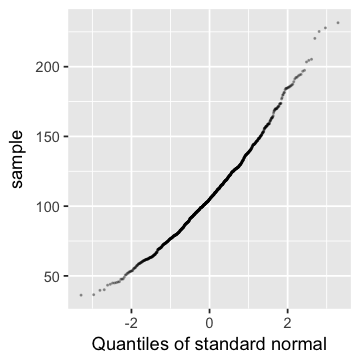

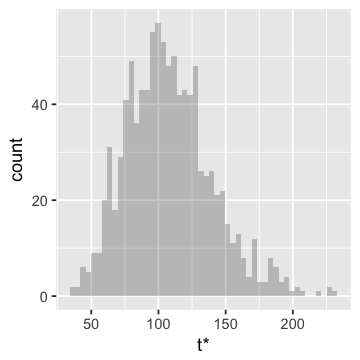

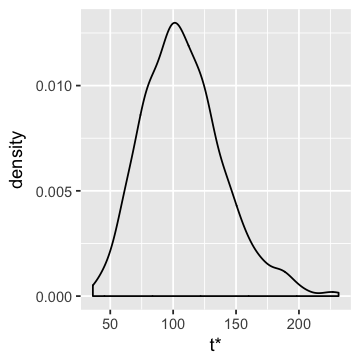

In [9]:
sim = data.frame(tstar = sapply(1:999, function(x) { mean(rexp(n=nrow(d), rate=fit.exp$estimate['rate']))}))
options(repr.plot.width=3, repr.plot.height=3)
ggplot(sim, aes(sample=tstar)) + geom_qq(size=0.2, alpha=0.3) + xlab('Quantiles of standard normal')
ggplot(sim, aes(x=tstar)) + geom_histogram(bins=50, alpha=0.3, ) + xlab('t*') 
ggplot(sim, aes(x=tstar)) + xlab('t*') + geom_density()

[1] -45.71734  55.91074

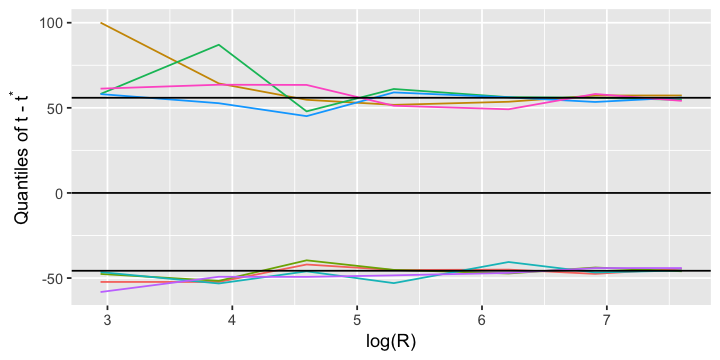

In [10]:
set.seed(1234)

# Theoretical confidence interval based on fitted exponential distribution.
# Sampling distribution of the sample mean of X ~ exp(rate) is gamma(n, n*rate)
n = length(d$y)
rate = fit.exp$estimate['rate']
interval = qgamma(c(0.05, 0.95), shape = n, rate = n*fit.exp$estimate['rate']) - mean(d$y)
interval

# Estimate quantile from bootstrap sample
q = function(p, sim) {   
    R = length(sim)
    sort(sim)[round((R+1)*p)]
}

p = do.call(rbind, lapply(c(19, 49, 99, 199, 499, 999, 1999),
        function(r) {
            do.call(rbind, lapply(1:4, 
                function(path) {
                    b = boot(data=d, statistic=air.fun, R=r, sim='parametric', ran.gen=air.rg, mle=fit.exp$estimate['rate'])
                    a = q(c(0.05, 0.95), b$t - b$t0)
                    data.frame(R=log(r), path, lower=a[1], upper=a[2])
                }))
        })) %>% gather(ul, quantile, -R, -path)

p$col = p %>% group_indices(path, ul) %>% as.factor
options(repr.plot.width=6, repr.plot.height=3)
ggplot(data=p, aes(x=R, y=quantile, col=col, group=col)) + 
    geom_path() + 
    geom_hline(yintercept = c(0, interval)) +
    xlab('log(R)') +
    ylab(expression('Quantiles of t - t'^'*')) +
    theme(legend.position="none")

### 2.3 Non-Parametric Simulation

If we have no parametric model but can assume that the samples obtained from our population of interest are identically and independently distributed according to an unknown CDF $F$, then we can use the _Parametric Bootstrap_ method to determine statisitcal properties of our estimator. In this case we use the EDF $\hat{F}$ just as we would a parametric model.

Since the EDF puts equal probablities on each of the original sample values, $y_1,...,y_n$, each $Y^*$ is independently sampled at random from the those data values. Therefore the simulated sample $Y_1,...,Y_n$ is a random sample taken with replacement from the data. The process must be extended when samples are non-homogeneous but in most cases this extension is straightforward.

In the case of the average, exact moments under sampling from the EDF can easily be found:

$$ E^*(\bar{Y}^*) = E^*(Y^*) = \sum_{j=1}^{n}\frac{1}{n}y_j = \bar{y} $$

and similarly:

$$ Var^*(\bar{Y}^*) = \frac{1}{n}Var^*(Y^*) = \frac{1}{n} E^*\{Y^* - E^*(Y^*)\}^2 = \frac{1}{n}\sum_{j=1}^{n} \frac{1}{n}(y_j - \bar{y})^2 $$

$$ = \frac{(n-1)}{n} . \frac{1}{n(n - 1)}\sum_{j=1}^{n}(y_j - \bar{y})^2 $$

Apart from the factor $(n-1)/n$, this the usual result for the estimated variance of $\bar{Y}$.


#### Plug-in Principle and Robust Estimators

The plug-in principle is a method of statistical estimation where we evaluate the same statistical function on the empirical distribution based on a sample. For example, when estimating the population mean, the plugin principle uses the sample mean; to estimate the population median, it uses the sample median; to estimate the population regression line, it uses the sample regression line. The non-parametric bootstrap method is a canonical example of the plug-in principle.

Consistency is a desirable property for estimators. Consistency implies that as $\hat{F} \rightarrow F$ so $T(\hat{F}) \rightarrow T(F)$ i.e. as our sample becomes larger so the estimator converges on the true population value. Consistency of plugin estimators requires certain conditions on the smoothness of $T(F)$. We assesses this requirement via the _influence function_ of $T(F)$. This function characterizes the effect on functional $t(.)$ of contaminating the distribution $F$ with a small amount of additional data. This practice has a long history in statistics and the investigation of estimators.

Specifically, the influence function for functional $t(F)$ evaluated at $y$ is:

$$ L_t(y;F) = lim_{\epsilon\to0} \frac{t\{(1-\epsilon)F + \epsilon H_y \} - t(F)}{\epsilon} = \frac{\partial t\{(1-\epsilon)F + \epsilon H_y \}}{\partial \epsilon} \Big\rvert_{\epsilon=0} $$

where $H_y(u)$ is the Heaviside step function jumping from 0 to 1 at $u = y$ and represents the contamination of the distribution.

Based soley on the _influence function_ and the _central limit theorum_, we can approximate the distribution of an unbiased estimator $t(.)$ as:

$$ T - \theta \sim N(0, v_L(F)) $$

where $ v_L(F) = \frac{1}{n} \int L_t^2dF(y) $

In practice $v_L$ is approximated by substituting $\hat{F}$ for $F$ i.e. by using the sample version. This is known as the __non-parametric delta method variance estimate__. The distribution defined by the approximated distribution above serves as a useful diagnostic when evaluating application of the bootstrap process or any other estimators for that matter since no assumptions are made regarding the underlying population. 

#### Example 2.8
Using the first 10 rows in the city data in _Example 1.2_, we perform a 9 sample non-parametric bootstrap to estimate the bias and variance of $T$ at 0.043 and $(0.022)^2 = 0.049$ respectively.

To assess our assumptions of a normal distribution of the estimator, we plot a histogram of the bootstrap samples. This shows evidence of non-normality, the distribution being skewed to the left. Also, the variance estimate is appreciably bigger than the value $v_L = 0.0325$ given by the delta method variance estimate. In this case there is evidence than a normal approximation would be inaccurate.

$$ v_L = \frac{1}{n^2} \sum_{j=1}^n \frac{(x_j - tu_j)^2}{\bar{u}^2} $$

To address the issue of non-normality we can use the same simulation to estimate distributions of related statistics, such as transformed estimates or studentized estimates (discussed below). We plot the studentized distribution $z^*$ below using a bootstrapped estimate for $v_L$ and still see evidence of a non-normal skew in the distribution.

To assess the effect of sample size $(n = 10)$ on our estimates, we look at the alignment of the following three curves for the original 10 samples as well as the full data set of 49 samples:

* Kernel density estimate of the bootstrap samples (red).
* The $N(b,v)$ bootstrap approximation calculated from the same bootstrap samples (green).
* The $N(0, v_L)$ approximation (blue).

The misalignment of curves based on 10 sample bootstrap is significant compared to that with the full data set of 49 samples. This is a strong indication that a larger sample size if required for accurate estimation.



ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = d, statistic = city.fun, R = 999, sim = "ordinary", 
    stype = "w")


Bootstrap Statistics :
    original    bias    std. error
t1* 1.520313 0.0433184   0.2215222

[1] 0.03248773

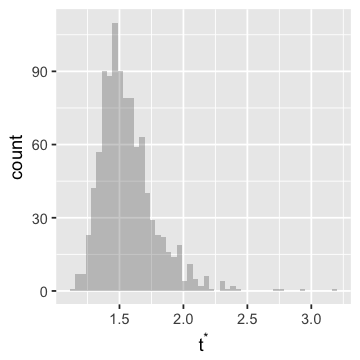

In [18]:
# The statistical function we are using as an estimator: the ratio of the sample means T = Xbar/Ubar in this case
city.fun = function(data, weights) {
               sum(data$x * weights) / sum(data$u * weights)
           }

set.seed(1234)
d = city %>% head(n=10)
b = boot(data=d, statistic=city.fun, R=999, sim='ordinary', stype='w')
b

# delta method variance estimate
t = mean(d$x) / mean(d$u)
n = dim(d)[1]
vl = sum((d$x - t*d$u)^2 / mean(d$u)^2) / n^2
vl

# Plot histogram
options(repr.plot.width=3, repr.plot.height=3)
data.frame(tstar=b$t) %>% ggplot(aes(x=tstar)) + geom_histogram(bins=50, alpha=0.3) + xlab(expression(t^'*'))

[1] 0.04299065

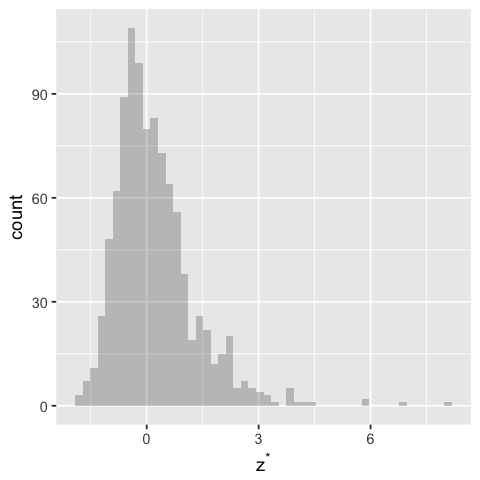

In [12]:
# Studentized distribution 
set.seed(1234)
deltavar.fun = function(data, indices) {
                   d = data[indices,]
                   sum((d$x - t*d$u)^2 / mean(d$u)^2) / n^2
               }

# Estimate vl
vl_star = boot(data=d, statistic=deltavar.fun, R=1, sim='ordinary', stype='i')$t[1]
vl_star

# Studentize 
z_star = (b$t - b$t0)/vl_star^(1/2)

# Plot histogram
options(repr.plot.width=3, repr.plot.height=3)
data.frame(zstar = (b$t - b$t0)/vl_star^(1/2)) %>% 
    ggplot(aes(x=zstar)) + geom_histogram(bins=50, alpha=0.3) + xlab(expression(z^'*'))

[1] 0.001163964

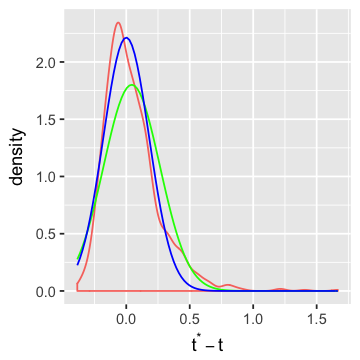

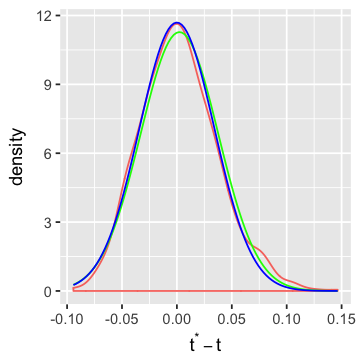

In [13]:
options(repr.plot.width=3, repr.plot.height=3)

# Overlay curves of 
# * Bootstrap samples kernel density estimate
# * Bootstrapped N(b, v) approximation
# * N(0, vl) approximation.
# 
# n = 10
bias = mean(mean(b$t) - b$t0)
stderr = sd(b$t)
data.frame(tstar=b$t) %>% ggplot(aes(x=tstar - b$t0)) + 
    geom_density(aes(col='red')) + 
    stat_function(fun=dnorm, col = 'green', args=list(mean=bias, sd = stderr )) +
    stat_function(fun=dnorm, col = 'blue', args=list(mean=0, sd = sqrt(vl))) +
    xlab(expression(t^'*'-t)) +
    theme(legend.position="none")

# n = 49
set.seed(1234)
b49 = boot(data=city, statistic=city.fun, R=999, sim='ordinary', stype='w')
bias = mean(mean(b49$t) - b49$t0)
stderr = sd(b49$t)

# delta method variance estimate
t = mean(city$x) / mean(city$u)
n = dim(city)[1]
vl49 = sum((city$x - t*city$u)^2 / mean(city$u)^2) / n^2
vl49

data.frame(tstar=b49$t) %>% ggplot(aes(x=tstar - b49$t0)) + 
    geom_density(aes(col='red')) + 
    stat_function(fun=dnorm, col = 'green', args=list(mean=bias, sd = stderr )) +
    stat_function(fun=dnorm, col = 'blue', args=list(mean=0, sd = sqrt(vl49))) +
    xlab(expression(t^'*'-t)) +
    theme(legend.position="none")

#### 2.3.1 Comparison with parametric methods
Non-parametric methods can be used to assess the suitability of the assumptions made in a parametric approach. 

As an example, consider the results of applying a non-parametric approach to the air conditioning data in example 1.1. One might naively expect results similar to the parametric approach in which we assume an exponential model. 

We see a discrepancy between the empirical quantiles (p=0.05, 0.095) of $T - t^*$ under non-parametric resampling. The horizontal lines show the exact quantiles based on the fitted exponential model.

Also, in Q-Q plots of $\bar{y}^*$ under non-parametric resampling we see a better match to the theoretical quantiles under the gamma model than the exponential which is consistent with our knowledge of the true population distribution.

__Figure 2.7__

[1] -45.71734  55.91074

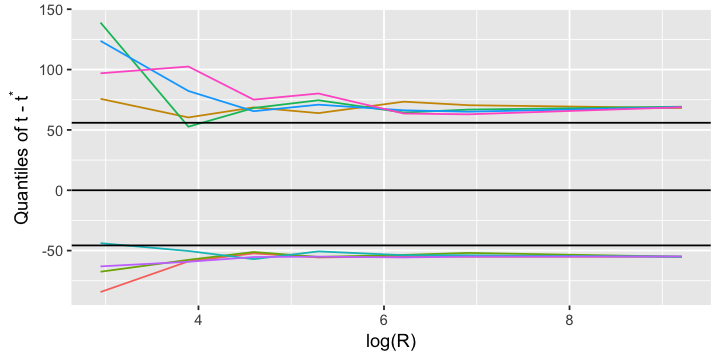

In [14]:
set.seed(1234)
d = data.frame(y = c(3, 5, 7, 18, 43, 85, 91, 98, 100, 130, 230, 487))

# Theoretical confidence interval based on fitted exponential distribution.
# Sampling distribution of the sample mean of X ~ exp(rate) is gamma(n, n*rate)
n = length(d$y)
rate = fit.exp$estimate['rate']
interval = qgamma(c(0.05, 0.95), shape = n, rate = n*fit.exp$estimate['rate']) - mean(d$y)
interval

# The statistical function we are using as an estimator: the sample mean in this case.
air.fun.nonparam = function(data, weights) {
    return(sum(data$y * weights))
}

# Estimate quantile from bootstrap sample
q = function(p, sim) {  
    R = length(sim)
    sort(sim)[round((R+1)*p)]
}

p = do.call(rbind, lapply(c(19, 49, 99, 199, 499, 999, 9999),
        function(r) {
            do.call(rbind, lapply(1:4, 
                function(path) {
                    b = boot(data=d, statistic=air.fun.nonparam, sim='ordinary', stype='w', R=r)
                    a = q(c(0.05, 0.95), b$t - b$t0)
                    data.frame(R=r, path, lower=a[1], upper=a[2])
                }))
        })) %>% gather(ul, quantile, -R, -path)


p$col = p %>% group_indices(path, ul) %>% as.factor
options(repr.plot.width=6, repr.plot.height=3)
ggplot(data=p, aes(x=log(R), y=quantile, col=col, group=col)) + geom_path() + 
    geom_hline(yintercept = c(0, interval)) +
    ylab(expression('Quantiles of t - t'^'*')) +
    theme(legend.position="none") 

In [15]:
# Non-parametric bootstrap of airconditioning data
set.seed(1234)
b = boot(data=d, statistic=air.fun.nonparam, sim='ordinary', stype='w', R=999)

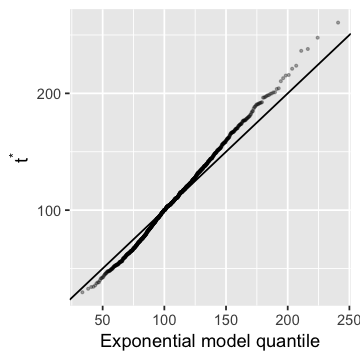

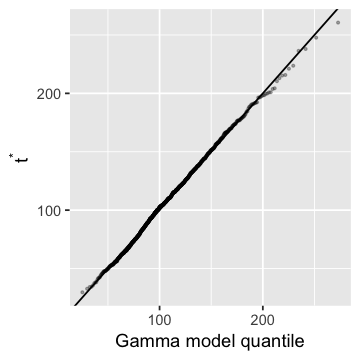

In [16]:
options(repr.plot.width=3, repr.plot.height=3)
d = data.frame(y = c(3, 5, 7, 18, 43, 85, 91, 98, 100, 130, 230, 487))
rate.exp = fit.exp$estimate['rate']
shape = fit.gamma$estimate['shape']
rate.gamma = fit.gamma$estimate['rate']

# Exponential model: sampling distribution of the sample mean of exponential distribution is gamma
ggplot(data=data.frame(tstar=b$t), aes(sample=tstar)) + 
    stat_qq(size = 0.5, alpha=0.3, distribution = qgamma, dparams = list(shape = n, rate = n*rate.exp)) +
    geom_abline(slope = 1, intercept = 0) +
    xlab('Exponential model quantile') + 
    ylab(expression(t^'*'))

# Gamma model: use the normal approximation of the sampling distribution of sample mean
ggplot(data=data.frame(tstar=b$t), aes(sample=tstar)) + 
    stat_qq(size = 0.5, alpha=0.3, distribution = qgamma, dparams = list(shape = n*shape, rate = n*rate.gamma)) +
    geom_abline(slope = 1, intercept = 0) +
    xlab('Gamma model quantile') + 
    ylab(expression(t^'*'))

### 2.4 Confidence Intervals
The simplest approach to generating confidence intervals via the bootstrap method, is to use a normal approximation to the distribution of $T$ which requires only estimates of bias and varaince. As we have seen in previous examples, a normal approximation will not always suffice. 

Alternatively we can use bootstrap estimates of quantiles of $T - \theta$ as described previously. In this case an equitailed $(1- 2\alpha)$ confidence interval will hve limits:

$$ t - (t^*_{((R+1)(1-\alpha))} - t), \; t - (t^*_{((R+1)(\alpha))} - t) $$

These are called the __basic bootstrap confidence limits__. Their accuracy depends on the number of bootstap samples, $R$. But accuracy also depends on the extend to which the distibution of $T^* - t$ agrees with that of $T - \theta$. Complete agreement will occur if $T - \theta$ has a distribution not depending on any unknowns. Quantities exhibiting this property are called __pivots__. 

If, as is usually the case, the distribution of $T - \theta$ does depend on unknowns, then we can try alternative expressions contrasting $T$ and $\theta$, such as differences of transformed quantities, or studentized versions of $T - \theta$ as:

$$ Z = \frac{T - \theta}{V^{1/2}} $$

where $V$ is an estimate of $var(T|F)$. 

Generally we will use the estimate of $V$ obtained by the __non-parametric delta method variance estimate__ described above. The idea is to mimic the Student-_t_ statistic which has this form and which eliminates the unknown standard deviation when making inference about a normal mean. 

With variance estimated, we could use quantiles of the _Student-t_ ditribution to directly to calculate confidence intervals or the _Z_ distribution, if sample size is sufficiently large. However, it is generally more accurate to estimate quantiles of _Z_ from replicates of the _studentized bootstrap statistic_

$$ Z^* = \frac{(T - t)}{V^{1/2}} $$

where $T^*$ and $V^*$ are based on a simulated sample $Y^*_1,...,Y^*_n$.

This studentized bootstrap is most likely to be of use in non-parametric problems. With parametric models we can sometimes find exact solutions using properties of the model.

#### Example 2.11 Air-conditioning data

Under the exponential model for Example 1.1 we have $T = \bar{Y}$ and since $var(T|F_\mu) = \mu/n$, we would take $V = \bar{Y}^2/n$. This gives a studentized statistic:

$$ Z = \frac{(T - \mu)}{V^{1/2}} = n^{1/2}(1 - \mu/\bar{Y}) $$

This is an exact _pivot_ (no unknowns) since $Q = \bar{Y}/\mu$ has the _gamma_ distribution with shape $n$ and scale $1/n$ for a mean of $1$. Simulation to construct confidence intervals is unecessary since gamma quantiles are available. 

Parametric simulation would be based on the _pivot_ directly $Q^* = \bar{Y}^*/t$ there $\bar{Y}^*$ is the average of a random sample taken from the exponential distribution with mean $t$. Since $Q^*$ has the same distribution as $Q$, the only error incurred by simulation would be due to randomness of the simulated quantiles. 



In [17]:
# Incomplete example 2.11
n = length(d$y)

# Exact quantiles of pivot
Q = qgamma(c(0.025, 0.975), shape = 12, rate = 12)
Q

[1] 0.5167146 1.6401699

## Reducing Error
The errors in resampling methods is generally a combination of __statistical error__ and __simulation error__. The first is due to the difference between $F$ and $\hat{F}$, and the magnitude of the resulting error will depend on our choice of $T$. The simulation error is incurred due to empirical estimates of properties under sampling from $\hat{F}$ rather than exact properties.

The plot in figure 2.7 is of successive non-parametric boostrap estimates of the example 1.1 population mean at increasing values of $R$. The decreasing simulation error shows as reduced scatter at increasing values of $R$. Statistical error is reflected in the difference between the simulated non-parametric quantiles for large R and the horizontal lines which indicate the quantiles under the exponential model.

### Statistical Error
The idea of the bootstrap method is to approximate the value of a statistical function $c(F)$ by the estimate $c(\hat{F})$. The statistical error is the difference between $c(F)$ and $c(\hat{F})$. We wish to minimize this as far as possible, or remove entirely.

#### Parametric problems
In parametric problems, assuming our selection of model is correct, $F$ and $\hat{F}$ will differ only in parameter values. It is desirable to define our problem in terms of statistical function $T$ that is a __pivot__ i.e. exhibits constant behaviour under all values of the model parameters. 

Strategies exist for reducing the variance in our statisitcal function with respect to the model parameters. These include applying transforms to $T - \theta$ or studentizing this quantity. Different transforms can be examined by simulation under different models close to the fitted model. Comparing changes in variance or selected quantiles, the pivotal or non-pivotal behaviour of a transform can be diagnosed.

#### Non-parametric problems
In a non-parametric setting, we cannot simulate data from a distribution with the same form as $F$ since that form is unknown. However we can simulate data from disributions similar to $\hat{F}$. 


### Simulation Error
Simulation error arises when Monte Carlo simulations are performed and properties of statistics are approximated by their empirical properties in these simulations. This simulation variability can only be eliminated entirely by an infinite simulation, which is impossible and uneccessary in practice. The challenge is to determine the size of $R$ necessary to achieve reasonable accuracy relative to the statistical accuracy of the quantity being approximated by simulation.